In [ ]:
import pandas as pd
import numpy as np
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
import matplotlib.pyplot as plt
!pip install pmdarima

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Product Blender bottle

# Data importation

In [ ]:
df=pd.read_csv("C:\\Users\\abhis\\Downloads\\Project\\predicted_sentiment (1).csv")
backup=df.copy()

In [ ]:
df = df.loc[df['asin'] == "B0010JLMO8"]

In [ ]:
df.head(5)

,Unnamed: 0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,sentiment
389931,389931,93594,A12SP1870ZTS3Q,B0010JLMO8,a89,"[0, 0]",love use everyay! gym realli help great shaker...,5,Love this!,1364342400,"03 27, 2013",Health and personal care,3
389932,389932,93595,A1BSM4T0BABH0C,B0010JLMO8,Aaron,"[0, 0]","thik oe prouct seem realli useful, wis beig si...",4,Works well,1367107200,"04 28, 2013",Health and personal care,5
389933,389933,93596,A1LYSN8RKX5VY2,B0010JLMO8,Aaron,"[0, 0]",pros:-urable-fuctio well-easi clea (the mixig ...,5,worth the money,1402963200,"06 17, 2014",Health and personal care,3
389934,389934,93597,A2ROBO96G69ABZ,B0010JLMO8,AC,"[0, 0]",great bottl system mix poer liqui easier use c...,5,"Like the bottle, but a bit pricey",1382572800,"10 24, 2013",Health and personal care,2
389935,389935,93598,A2VEU46CA5QZ4O,B0010JLMO8,adam,"[0, 0]","awesom bottl , got two babys, mixig ball reall...",5,awesome cups got 2,1386115200,"12 4, 2013",Health and personal care,4


In [ ]:
# df=df[df["category"]=="Health and personal care"]

In [ ]:
df["category"].unique()

array(['Health and personal care'], dtype=object)

Time Series

In [ ]:
df.drop(["overall","unixReviewTime", "Unnamed: 0"], inplace= True, axis = 1)

In [ ]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])
df = df.set_index('reviewTime')

In [ ]:
df = df.resample("Q").mean()

In [ ]:
df

,index,sentiment
reviewTime,,
2008-09-30,94010.500000,3.500000
2008-12-31,93812.666667,4.666667
2009-03-31,93889.000000,4.500000
2009-06-30,94165.666667,3.000000
2009-09-30,94102.333333,4.333333
2009-12-31,93822.000000,4.000000
2010-03-31,93833.400000,3.800000
2010-06-30,93902.125000,3.625000
2010-09-30,94012.315789,3.736842


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition=seasonal_decompose(df["Very Satisfied"],period=4)
# d_trend=decomposition.trend
# d_seasonality=decomposition.seasonal
# d_residual=decomposition.resid
# import matplotlib.pyplot as plt
# decomposition.plot()
# plt.show()

# Decomposition of data 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(df['sentiment'],period=4)
d_trend=decomposition.trend
d_seasonality=decomposition.seasonal
d_residual=decomposition.resid

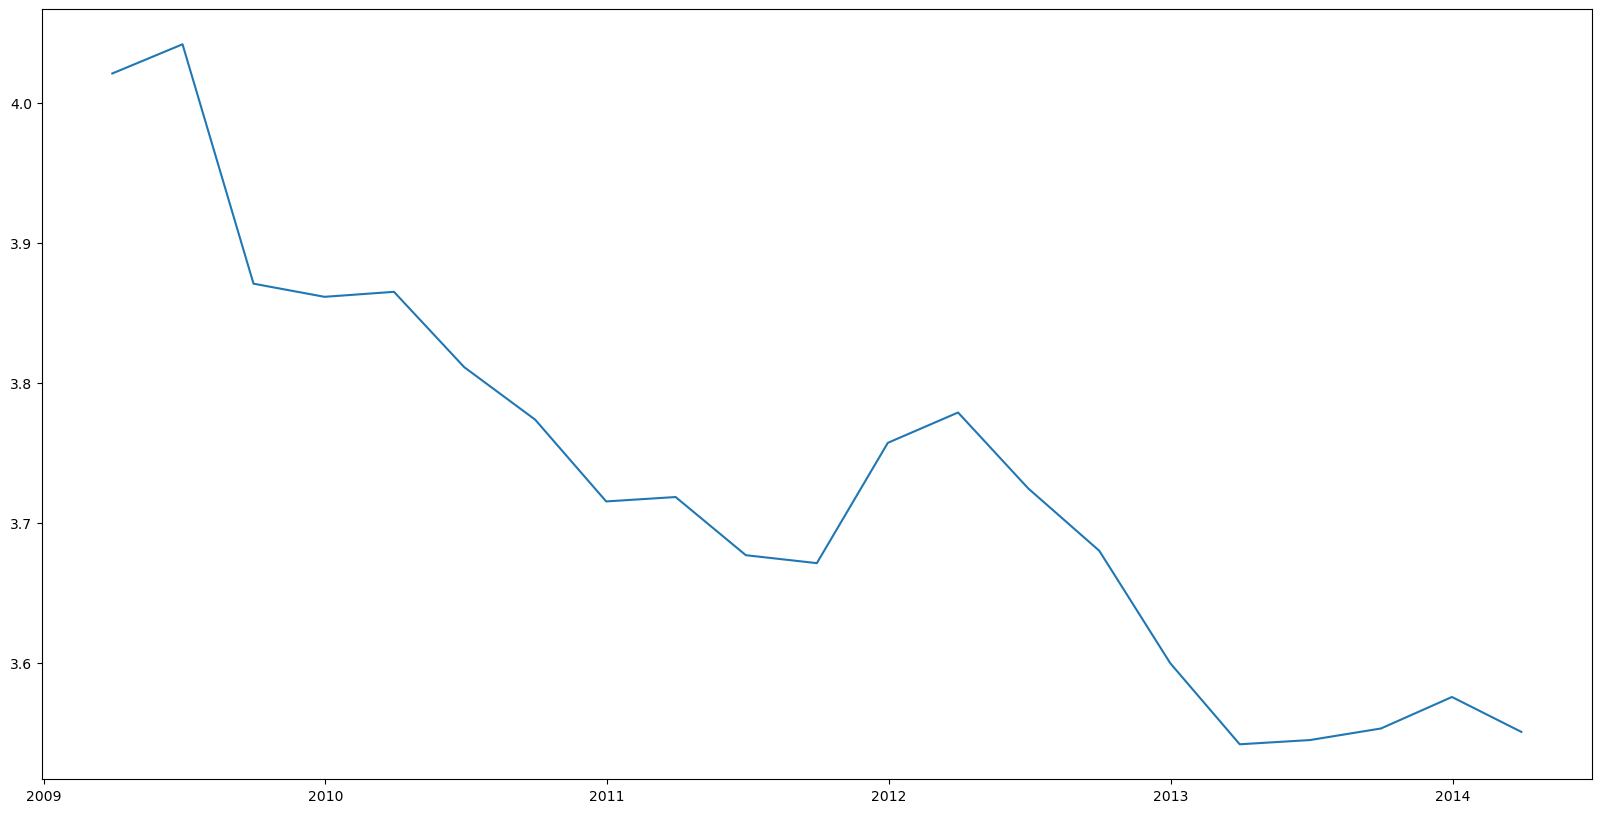

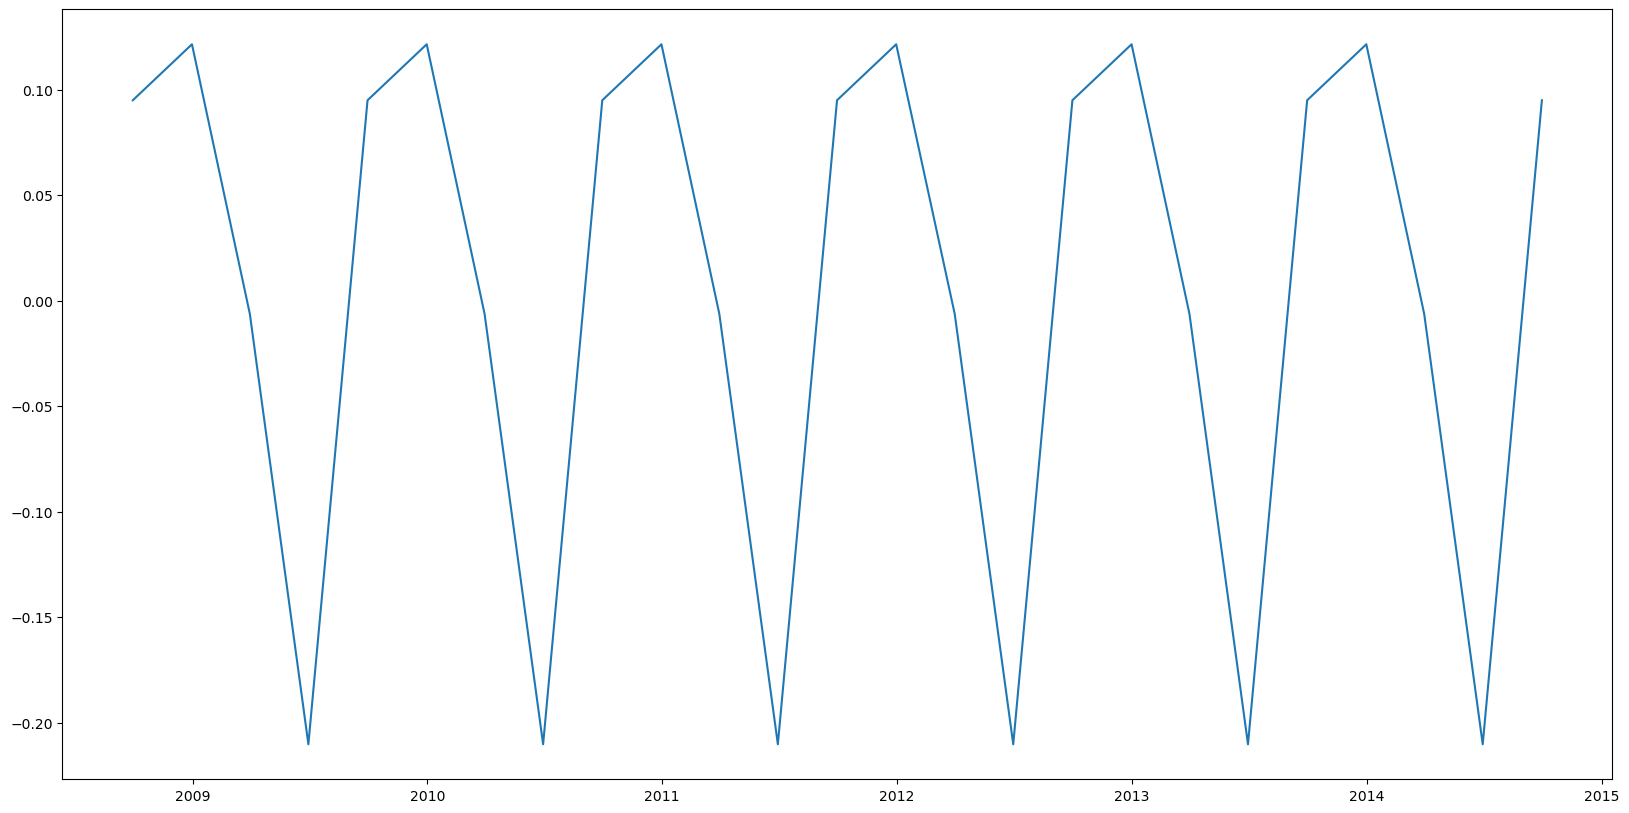

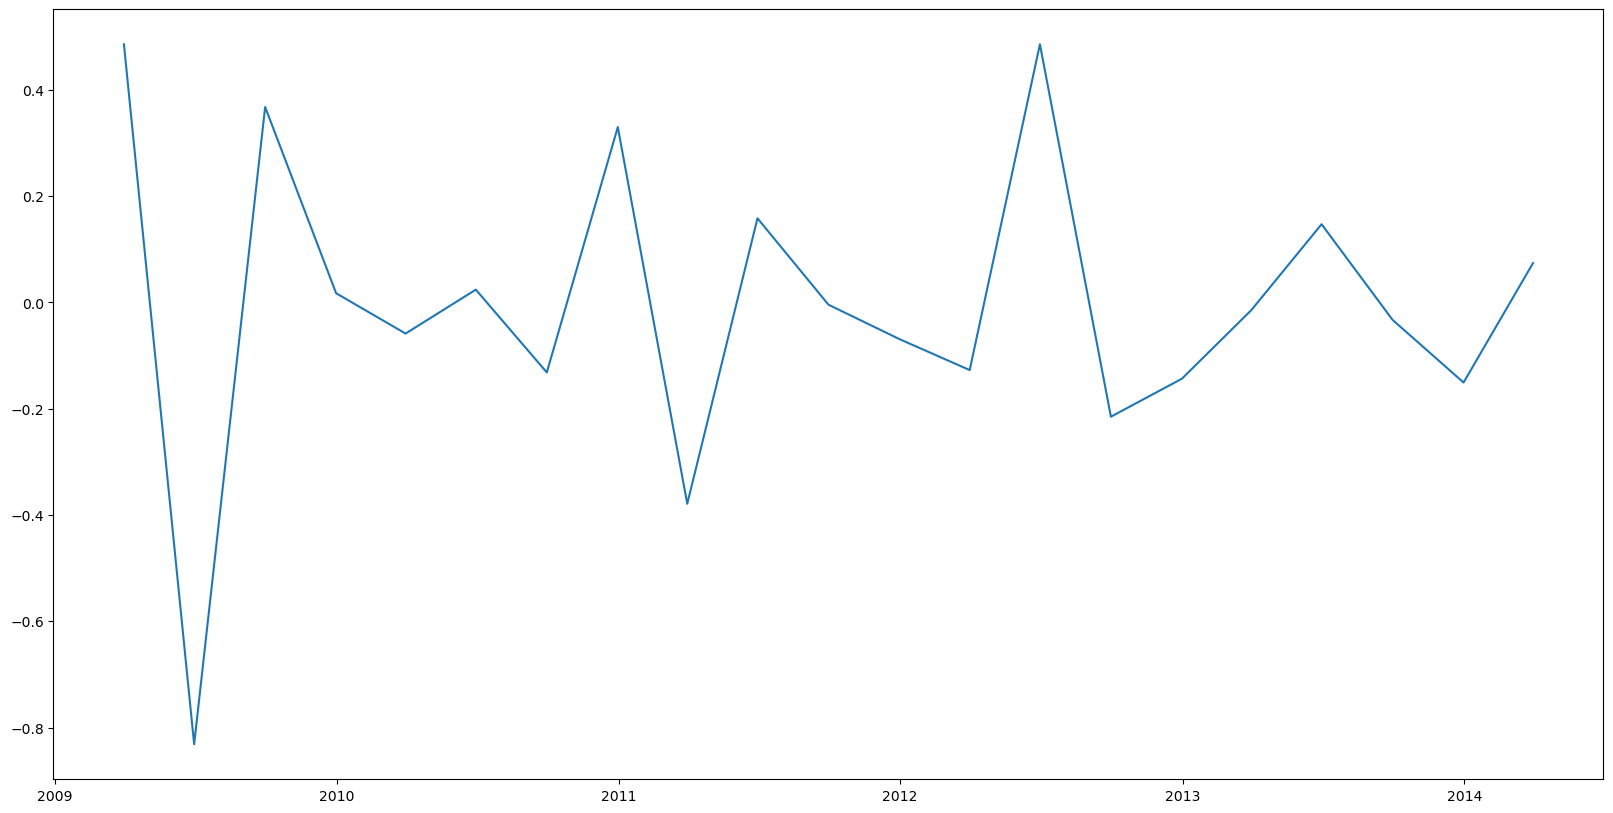

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(d_trend)
plt.figure(figsize=(20,10))
plt.plot(d_seasonality)
plt.figure(figsize=(20,10))
plt.plot(d_residual)

We can see from the above charts that the data has all 3 components trend seasonality and noise

### Checking Stationarity

In [ ]:
df = df['sentiment']

In [ ]:
# dickey-fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
def checkStationarity(df):
    pvalue = adfuller(df)[1]
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)
checkStationarity(df)

'p-value=2.0243214246732767e-05. Data is stationary'

According to Adifuller data is stationary 

# Using Autoarima to find optimal parameters 

In [ ]:
from pmdarima.arima import auto_arima
df_new = auto_arima(df,start_p=0,max_p=5, start_q=0,max_q=5, seasonal=True, trace=True)
print(df_new.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.643, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=38.410, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.647, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24.361, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=20.744, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=20.143, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=21.619, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=22.424, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=22.393, Time=0.05 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 0.839 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No

Auto arima gives us an optimal p,d,q values of (4,1,0) value

# Building sarima model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [ ]:
len(df)

25

In [ ]:
train = df.iloc[:15]
test = df.iloc[15:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 15, test = 10


In [ ]:
p=1; d=1; q=0
model = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(p,d,q,4)).fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         sentiment   No. Observations:                   15
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 -10.319
Date:                           Tue, 03 Jan 2023   AIC                             26.638
Time:                                   11:48:41   BIC                             27.546
Sample:                               09-30-2008   HQIC                            25.642
                                    - 03-31-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6379      0.354     -1.803      0.071      -1.331       0.055
ar.S.L4       -0.3103      0.572     -0.542

In [ ]:
start = len(train)
stop = len(train)+len(test)-1

In [ ]:
predictions = model.predict(start,stop,dynamic=True)
print("predictions", predictions)

predictions 2012-06-30    3.490643
2012-09-30    3.812029
2012-12-31    3.855597
2013-03-31    3.561900
2013-06-30    3.495918
2013-09-30    3.791899
2013-12-31    3.816415
2014-03-31    3.575803
2014-06-30    3.474086
2014-09-30    3.783221
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [ ]:
df_res = pd.DataFrame({'actual':df[9:],'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
df_res.dropna(inplace=True)
print(df_res)

              actual  predicted       err
2012-06-30  4.000000   3.490643  0.509357
2012-09-30  3.560000   3.812029 -0.252029
2012-12-31  3.577778   3.855597 -0.277819
2013-03-31  3.521277   3.561900 -0.040623
2013-06-30  3.481928   3.495918 -0.013990
2013-09-30  3.615385   3.791899 -0.176514
2013-12-31  3.546512   3.816415 -0.269903
2014-03-31  3.618557   3.575803  0.042753
2014-06-30  3.564516   3.474086  0.090430
2014-09-30  3.333333   3.783221 -0.449888


In [ ]:
msg = 'ARMA Model. Order=(' + str(0) + ',' + str(0) + ')'
mse1 = mean_squared_error(test,predictions )
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(0,0)
	MSE = 0.07184017421858088
	RMSE = 0.26803017408228663


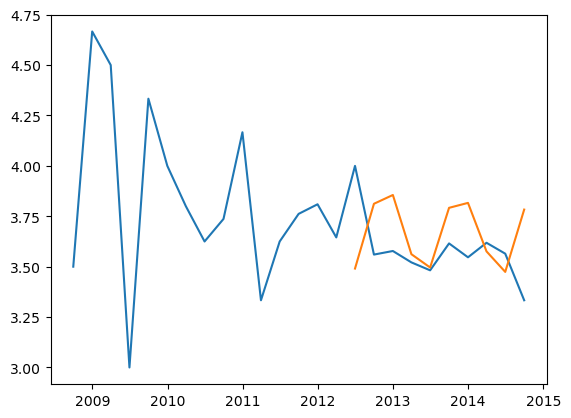

In [ ]:
plt.plot(df)
plt.plot(predictions)

In [ ]:
model = sm.tsa.statespace.SARIMAX(df,order=(p,d,q),seasonal_order=(p,d,q,4)).fit()

In [ ]:
forecast = model.forecast(10)

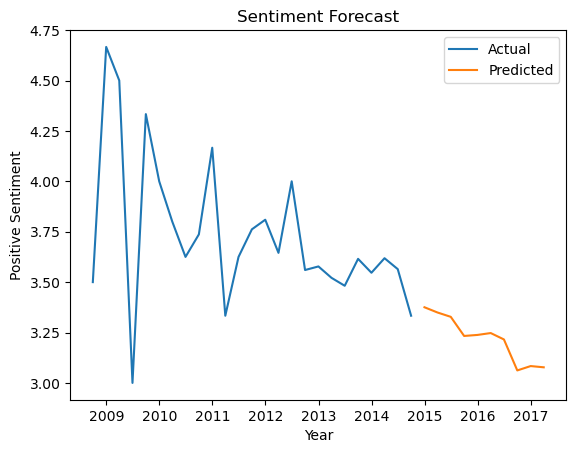

In [ ]:
plt.plot(df)
plt.xlabel("Year")
plt.ylabel("Positive Sentiment")
plt.title('Sentiment Forecast')
plt.plot(forecast)
plt.legend(['Actual','Predicted'])
plt.show()